# Use emcee to sample Lya posterior as a function of mean flux

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import numpy as np
import sys
import os
import json
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['savefig.dpi'] = 120
mpl.rcParams['figure.dpi'] = 120
import cProfile
import emcee
# our own modules
import simplest_emulator
import linear_emulator
import data_PD2013
import mean_flux_model
import thermal_model
import camb_cosmo
import fit_linP
import recons_cosmo
import compute_likelihood
import lya_theory

## Setup Lya likelihood function

In [2]:
# read P1D measurement
basedir='../../p1d_data/data_files/PD2013/'
data=data_PD2013.P1D_PD2013(basedir=basedir,blind_data=True)
zs=data.z
Nz=len(zs)

In [3]:
# load P1D emulator
basedir='../../p1d_emulator/sim_suites/emulator_04052019/'
p1d_label='mf_p1d'
skewers_label='Ns100_wM0.1'
emu=linear_emulator.LinearEmulator(basedir,p1d_label,skewers_label,max_arxiv_size=5000,verbose=False)

setup interpolator for coefficient 0
[ 0.34215808 -2.30000012  0.64144805  0.14339793  1.47513694] test [-1.18323575]
setup interpolator for coefficient 1
[ 0.34215808 -2.30000012  0.64144805  0.14339793  1.47513694] test [-0.6323589]
setup interpolator for coefficient 2
[ 0.34215808 -2.30000012  0.64144805  0.14339793  1.47513694] test [-0.29370814]
setup interpolator for coefficient 3
[ 0.34215808 -2.30000012  0.64144805  0.14339793  1.47513694] test [-0.1279153]
setup interpolator for coefficient 4
[ 0.34215808 -2.30000012  0.64144805  0.14339793  1.47513694] test [-0.01945575]


In [4]:
# setup theory to predict Lya 1D power
theory = lya_theory.LyaTheory(zs,emulator=emu,verbose=False)
# for this simple test, just use fiducial cosmology
theory.set_cosmo_model(linP_model=theory.cosmo.linP_model_fid)
linP_Mpc_params=theory.cosmo.get_linP_Mpc_params()

Note: redshifts have been re-sorted (earliest first)


In [5]:
# setup nuisance models
mf_model=mean_flux_model.MeanFluxModel()
T_model=thermal_model.ThermalModel(ln_gamma_coeff=[np.log(1.4)])
theory.set_mf_model(mf_model)
theory.set_T_model(T_model)

In [6]:
# test chi2 function
compute_likelihood.get_chi2(data,theory,linP_Mpc_params=linP_Mpc_params,verbose=False)

7452.4575247758785

In [7]:
#cProfile.run("compute_likelihood.get_chi2(data,theory,linP_Mpc_params=linP_Mpc_params,verbose=False)",sort='cumtime')

### Setup function to be called in MCMC

In [8]:
def get_ln_tau_0(x):
    ln_tau_min=-1.0
    ln_tau_max=-0.8
    return ln_tau_min+x*(ln_tau_max-ln_tau_min)

In [9]:
def lnprob(x,data,theory,linP_Mpc_params):
    # for now priors are top hats in 0 < x < 1
    if max(x) > 1.0: 
        return -np.inf
    if min(x) < 0.0:
        return -np.inf
    ln_tau_0 = get_ln_tau_0(x[0])
    mf_model=mean_flux_model.MeanFluxModel(z_tau=3.0,ln_tau_coeff=[3.18,ln_tau_0])
    theory.set_mf_model(mf_model)
    # compute chi2        
    chi2=compute_likelihood.get_chi2(data,theory,linP_Mpc_params=linP_Mpc_params,verbose=False)
    loglike=-0.5*chi2
    # add smooth, weak prior to alleviate NGP in likelihood
    loglike -= (x[0]-0.55)**2/0.01
    #print(x,'log like =',loglike)
    return -0.5*chi2

In [10]:
xs=np.linspace(0.0,1.0,100)
lnps=[lnprob([x],data,theory,linP_Mpc_params) for x in xs]

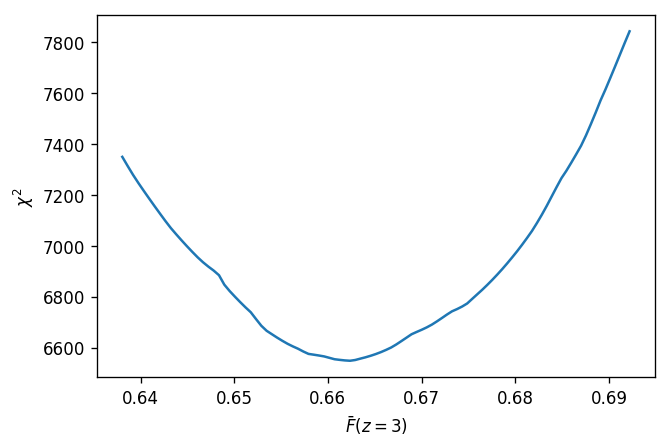

In [11]:
plt.plot(np.exp(-np.exp(get_ln_tau_0(xs))),-2.0*np.array(lnps))
plt.xlabel(r'$\bar F(z=3)$')
plt.ylabel(r'$\chi^2$')

### Setup MCMC

In [12]:
# for now we'll have only three dimensions (mean flux, temperature, gamma)
ndim=1
# setup initial walkers
nwalkers = 20
p0 = np.random.rand(ndim * nwalkers).reshape((nwalkers, ndim))

In [13]:
p0.flatten()

array([ 0.1860087 ,  0.80829699,  0.26126449,  0.07542495,  0.45730902,
        0.0518103 ,  0.31056594,  0.03568915,  0.04558064,  0.03229025,
        0.56824234,  0.99349733,  0.43482616,  0.66312071,  0.49953352,
        0.44359176,  0.73635219,  0.7674961 ,  0.47513415,  0.67279157])

In [14]:
# test function
lnprob(p0[0],data,theory,linP_Mpc_params)

-3554.2584938251011

In [15]:
# setup sampler
emu.arxiv.verbose=False
emu.verbose=False
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=[data,theory,linP_Mpc_params])

In [16]:
# burn-in phase
for i in range(1):
    pos, prob, state = sampler.run_mcmc(p0, 5)
    print(i,'finished at',pos.flatten(),prob)
    p0=pos

0 finished at [ 0.28498862  0.70524201  0.26193184  0.31979145  0.51977539  0.0518103
  0.41764119  0.19848798  0.04558064  0.35629923  0.56824234  0.73024244
  0.49155936  0.62280717  0.63299103  0.46204339  0.65602498  0.60387665
  0.56586716  0.66096159] [-3430.90080234 -3318.57637977 -3454.99186726 -3398.95764086 -3285.83755204
 -3804.39770424 -3338.20383235 -3534.30116104 -3818.08472163 -3374.53434735
 -3274.38860711 -3335.23344729 -3297.09257179 -3283.92802405 -3285.80386015
 -3314.60396578 -3292.1079809  -3279.45411569 -3274.28498258 -3295.40769419]


In [17]:
# reset and run actual chains
sampler.reset()
nsteps=100
for i, result in enumerate(sampler.sample(pos, iterations=nsteps)):
    if i % 100 == 0:
        print(i,result[0].flatten())

0 [ 0.28498862  0.65666735  0.26193184  0.31979145  0.51977539  0.0518103
  0.4595981   0.19848798  0.04558064  0.35629923  0.56824234  0.73024244
  0.62118337  0.5562151   0.63299103  0.46204339  0.65602498  0.60387665
  0.56586716  0.57804409]


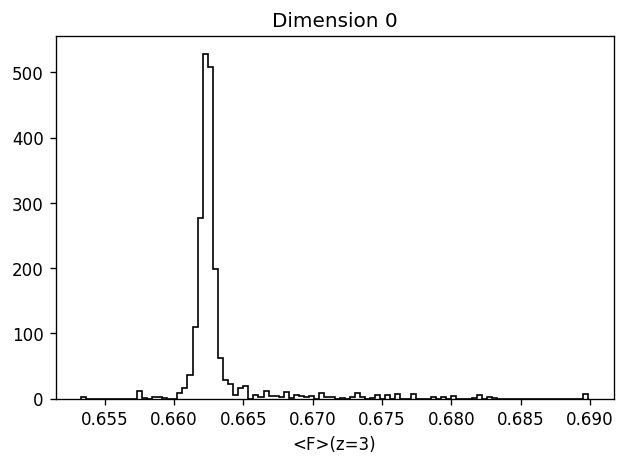

In [18]:
for i in range(ndim):
    plt.figure()
    plt.hist(np.exp(-np.exp(get_ln_tau_0(sampler.flatchain[:,i]))), 100, color="k", histtype="step")
    plt.xlabel('<F>(z=3)')
    plt.title("Dimension {0:d}".format(i))

In [19]:
print("Mean acceptance fraction: {0:.3f}".format(np.mean(sampler.acceptance_fraction)))

Mean acceptance fraction: 0.711


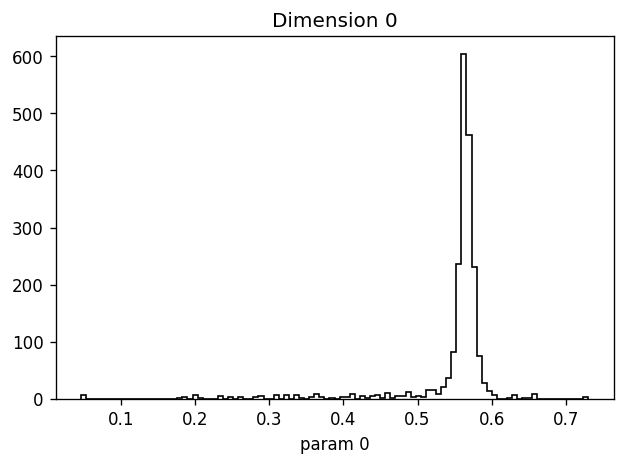

In [20]:
for i in range(ndim):
    plt.figure()
    plt.hist(sampler.flatchain[:,i], 100, color="k", histtype="step")
    plt.xlabel('param 0')
    plt.title("Dimension {0:d}".format(i))